In [2]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib

/Users/heeseok/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


검색어의 토픽을 정하기위해 기존에 fit된 LDA와 CounterVectorizer를 불러온다

In [3]:
lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=1, evaluate_every=-1,
                          learning_decay=0.7, learning_method='online',
                          learning_offset=10.0, max_doc_update_iter=100,
                          max_iter=15, mean_change_tol=0.001, n_components=21,
                          n_jobs=None, perp_tol=0.1, random_state=None,
                          topic_word_prior=0.1, total_samples=1000000.0,
                          verbose=0)

In [9]:
query_tf

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['말씀', '안녕', '서울', '서울시', '관리', '대한', '대해', '대하',
                            '민원', '관련', '경우', '가정', '행복', '해당', '사항', '내용',
                            '문의', '진행', '요청', '확인', '이용', '개최', '주민', '처리',
                            '나라', '서울특별시', '생각', '여부', '연락', '주신', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None,
                vocabulary=['가가', '가건물', '가게', '가격', '가결', '가계', '가곡', '가공',
                            '가관', '가구', '가기', '가까이', '가끔', '가나', '가내', '가능',
                            '가능성', '가다가', '가도', '가동', '가득', '가든', '가뜩이나', '가라',
                            '가락', '가량', '가로', '가로등', '가로막', '가로변', ...])

In [142]:
def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

In [143]:
terms = query_tf.get_feature_names()
get_topics(lda.components_,terms)

Topic 1: [('도로', 43078.28), ('차량', 18513.62), ('통행', 15790.54), ('인도', 9898.89), ('교통', 8973.07)]
Topic 2: [('버스', 16602.46), ('마을', 8077.66), ('교통', 7128.51), ('노선', 5306.89), ('운행', 4676.11)]
Topic 3: [('지역', 9250.17), ('용산', 8588.64), ('구민', 8177.66), ('거리', 5815.01), ('용산구', 5396.09)]
Topic 4: [('도서관', 10096.64), ('운영', 9536.04), ('홈페이지', 6018.47), ('정보', 4521.34), ('인터넷', 3529.12)]
Topic 5: [('건물', 25299.47), ('공사', 13739.08), ('건축', 12150.74), ('피해', 10348.98), ('신축', 9178.54)]
Topic 6: [('과태료', 15562.08), ('부과', 12785.23), ('단속', 12709.28), ('담배', 9883.02), ('위반', 8531.97)]
Topic 7: [('조합', 9140.97), ('주택', 8802.41), ('등록', 6349.41), ('서류', 4741.83), ('자동차', 4720.95)]
Topic 8: [('신고', 21056.63), ('접수', 10832.17), ('부서', 9636.09), ('시정', 8504.26), ('현장', 7743.94)]
Topic 9: [('안내', 10427.67), ('과장', 6524.26), ('강서', 6015.7), ('결과', 5295.77), ('지도', 4406.81)]
Topic 10: [('주차', 75573.89), ('단속', 46828.63), ('불법', 32862.47), ('차량', 32423.13), ('주차장', 20513.9)]
Topic 11: [('보호', 6507.

In [2]:
lda = joblib.load('minwon_lda.pkl')
query_tf = joblib.load('minwon_query_tf.pkl')

In [81]:
def set_query_topic(Q):
    """
    Q: 검색어 (str)
    return : topic번호 (0~14)
    """
    Q_ = [Q]
    query_tf_matrix = query_tf.fit_transform(Q_)
    t = lda.transform(query_tf_matrix)
    tnum=int(np.where(t[0]==max(t[0]))[0][0])
    
    if tnum==0 or tnum==1:
        return 0
    elif tnum==2 or tnum==3 or tnum==8:
        return 1
    elif tnum==4 or tnum==20:
        return 2
    elif tnum==5 or tnum==6 or tnum==7:
        return tnum-2
    elif tnum==9:
        return 6
    elif tnum==10 or tnum==13:
        return 7
    elif tnum==11 or tnum==12:
        return tnum-3
    elif tnum==14 or tnum==19:
        return 10
    else:
        return tnum-4

In [76]:
def district_stats(data,topic):
    """
    data : DB에서 불러온 1년치데이터로 만들어진 DataFrame
    topic : 검색어가 속한 토픽의 번호(0~14)
    return : 토픽번호(int), 토픽이름(str), 지역구별 해당토픽의 비율(numpy.ndarray)
    """
    
    districtNo = {"강서구":2 , "강남구":3, "강동구":4, "강북구":5,
               "관악구":6, "광진구":7, "구로구":8, "금천구":9,
               "노원구":10, "도봉구":11, "동대문구":12, "동작구":13,
               "마포구":14, "서대문구":15, "서초구":16, "성동구":17,
                "성북구":18, "송파구":19, "양천구":20, "영등포구":21,
                "용산구":22, "은평구":23, "종로구":24, "중구":25, "중랑구":26}
    
    topicNames = {0:"교통", 1:"기타", 2:"건축", 3:"흡연", 4:"서류,등록", 5:"불법,단속",
            6:"주차", 7:"가정,복지,동물", 8:"문화,체육", 9:"쓰레기", 10:"주거,아파트,재건축",
            11:"공사,소음", 12:"고객 응대", 13:"시설물 설치", 14:"위생"}
        
    #지역구별로 데이터프레임 생성.
    districtDataFrames = [data[data.site_no==v] for v in districtNo.values()]
    
    totalResult = []
    for df in districtDataFrames:
        temp=[]
        for i in range(0,15):
            temp.append(len([_ for _ in df.topic if _==i])/len(df)*100)
        totalResult.append(tuple(temp))
    topicResult = np.array([_[topic] for _ in totalResult])
    topicName = topicNames[topic]
    
    zipbObj = zip(districtNo.keys(), topicResult/max(topicResult))
    result=dict(zipbObj)
    final =list()
    for i in result.keys():
        temp={"name":i,"rate":result[i]}
        final.append(temp)
    
    result = {"topic":topic,"topicName":topicName,"result":final}
    json_result = json.dumps(result, indent="  ",ensure_ascii=False)    
    return json_result

In [63]:
def monthly_topic_stats(data,district,topic):
    """
    data : DB에서 불러온 1년치데이터로 만들어진 DataFrame
    district : 사용자가 클릭한 지역이름 ex)'송파구'
    topic : 검색어가 속한 토픽의 번호(0~14)
    return : 선택한 지역에서 1년간 해당토픽의 민원이 발생한 수(list)
    
    """
    
    districtNo = {"강서구":2 , "강남구":3, "강동구":4, "강북구":5,
           "관악구":6, "광진구":7, "구로구":8, "금천구":9,
           "노원구":10, "도봉구":11, "동대문구":12, "동작구":13,
           "마포구":14, "서대문구":15, "서초구":16, "성동구":17,
            "성북구":18, "송파구":19, "양천구":20, "영등포구":21,
            "용산구":22, "은평구":23, "종로구":24, "중구":25, "중랑구":26}
    
    data = data[data.site_no==districtNo[district]]
    
    now = datetime.now()
    dateList = []
    y = now.year
    m = now.month
    
    while len(dateList)<12:
        if m>0:
            dateList.append(str(y)+'-'+'{0:02d}'.format(m%12))
        elif m==0:
            y_ = y-1
            dateList.append(str(y_)+'-'+'{0:02d}'.format(m+12))
        else:
            y_ = y-1
            dateList.append(str(y_)+'-'+'{0:02d}'.format(m%12))
        m -=1
    
    
    monthlyDataFrames=[]    #최근 12개월의 데이터를 각각 1개월씩 데이터프레임으로 만들어 배열에저장
    for m in dateList:
        monthlyDataFrames.append(data[[_.startswith(m) for _ in data.date]])
    totalResult=[]    #최근 12개월의 민원중 해당 토픽의 민원의 갯수를 월별로 저장

    for df in monthlyDataFrames:
        totalResult.append(len([_ for _ in df.topic if _==topic]))
        
    return dateList,totalResult

데이터 불러오기

In [64]:
data= pd.read_csv('jin_final_data.csv')

/Users/heeseok/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


지역구별 통계

In [158]:
set_query_topic('교통 혼잡')

0

In [157]:
t_id, t_name, result =district_stats(data,set_query_topic('송파구 가로등 보수작업'))

ValueError: too many values to unpack (expected 3)

In [92]:
result

'{\n  "topic": 13,\n  "topicName": "시설물 설치",\n  "result": [\n    {\n      "name": "강서구",\n      "rate": 0.5003959074042448\n    },\n    {\n      "name": "강남구",\n      "rate": 0.3790022129471414\n    },\n    {\n      "name": "강동구",\n      "rate": 0.8145872335285947\n    },\n    {\n      "name": "강북구",\n      "rate": 0.5053848433949215\n    },\n    {\n      "name": "관악구",\n      "rate": 0.3357829282080272\n    },\n    {\n      "name": "광진구",\n      "rate": 0.41400817262886236\n    },\n    {\n      "name": "구로구",\n      "rate": 0.6326546332195034\n    },\n    {\n      "name": "금천구",\n      "rate": 0.21883289124668437\n    },\n    {\n      "name": "노원구",\n      "rate": 0.9082687846498644\n    },\n    {\n      "name": "도봉구",\n      "rate": 0.6453803425187762\n    },\n    {\n      "name": "동대문구",\n      "rate": 0.48463843035892623\n    },\n    {\n      "name": "동작구",\n      "rate": 0.6569380972164521\n    },\n    {\n      "name": "마포구",\n      "rate": 0.5313565170113549\n    },\n    {\n     

In [66]:
t_id,t_name,result

(13,
 '시설물 설치',
 array([0.50039591, 0.37900221, 0.81458723, 0.50538484, 0.33578293,
        0.41400817, 0.63265463, 0.21883289, 0.90826878, 0.64538034,
        0.48463843, 0.6569381 , 0.53135652, 0.54187192, 0.57796906,
        0.55348523, 1.        , 0.65050444, 0.71525412, 0.47528596,
        0.47278248, 0.77858439, 0.50446071, 0.36958444, 0.6083818 ]))

특정지역 선택시

In [167]:
dateList, result_ = monthly_topic_stats(data,"송파구",set_query_topic('송파구 가로등 보수'))

In [168]:
result_

[6, 14, 6, 9, 9, 7, 5, 16, 24, 12, 23, 32]

시설물 설치


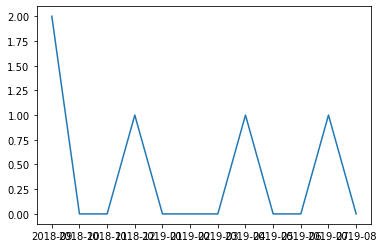

In [155]:
print(t_name)
plt.plot(dateList[::-1],result_[::-1])

LDA, CounterVectorizer 학습시킨과정

In [ ]:
stop_words = ['말씀', '안녕', '서울','서울시', '관리','대한','대해','대하','민원','관련','경우','가정','행복',
             '해당','사항','내용','문의','진행','요청','확인','이용','개최','주민','처리','나라','서울특별시',
             '생각','여부','연락','주신','구정','구청','시간','부탁','조치','의견','관심','첨부파일',
              '관련','하십니까','애정','하십니까','주시','고객','안녕하십니까','사람','시민','선생님','답변','신청',
             '기타','때문','현실','주무관','성심','성의껏','양해','다시','한번','다시한번','저희','때문','추후','질문',
             '어디','거기','여기','저기','실시','최선','먼저','성심껏','사진','사용','정말','문제','아래','불편','주시',
              '본인','업무','가정','행복','제발','정도','부분','읍니']

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
data_ = data[data.site_no!=0]
data_ = data_[data_.stie_no!=1]
num_removed=[re.sub('\d','',data_.controlled_collection.iloc[_]) for _ in range(len(data_.controlled_collection))]
raw_tf = CountVectorizer(max_features=5000,stop_words=set(stop_words))
raw_tf_matrix = raw_tf.fit_transform(num_removed)

In [ ]:
temp = []

for i in range(1,100):

    lda = LatentDirichletAllocation(n_components=i,learning_method='online',max_iter=10,
                                    doc_topic_prior=1, topic_word_prior=0.1)
    result = lda.fit_transform(raw_tf_matrix)
    terms = raw_tf.get_feature_names()
    get_topics(lda.components_,terms)
    perp = lda.perplexity(raw_tf_matrix)
    temp.append(perp)
    print(i,"preplexity : ",perp,'\n')

    


plt.plot(range(1,100),np.array(temp))

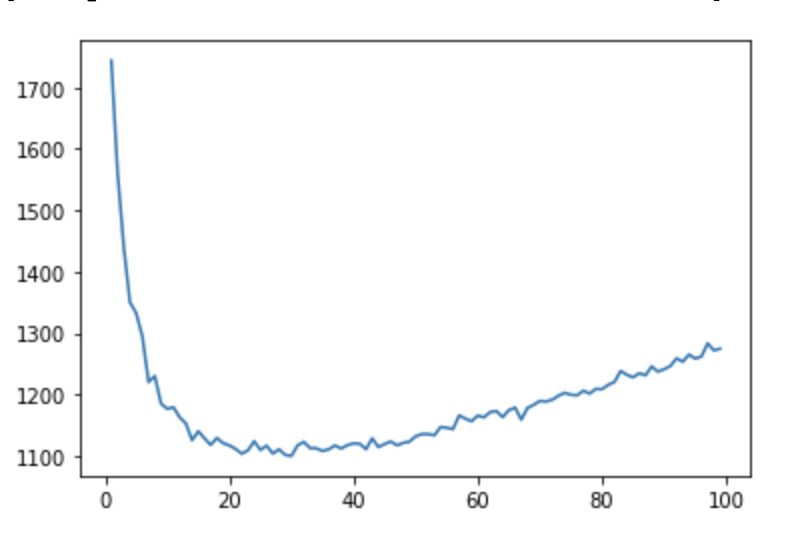

In [ ]:
lda = LatentDirichletAllocation(n_components=21,learning_method='online',max_iter=15,
                                doc_topic_prior=1, topic_word_prior=0.1)
result = lda.fit_transform(raw_tf_matrix)
terms = raw_tf.get_feature_names()
get_topics(lda.components_,terms)
perp = lda.perplexity(raw_tf_matrix)
print("preplexity : ",perp)
